In [ ]:
from utils import *
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the provided CSV files
outfit_data = pd.read_csv('datathon/dataset/outfit_data.csv')
product_data = pd.read_csv('datathon/dataset/product_data.csv')

In [ ]:
get_single_outfit(outfit_data, product_data, 769)

In [ ]:
plot_all_outfit_images(outfit_data, product_data)

In [ ]:
plot_outfits_for_similar_products(product_data, outfit_data, "53003736-94")

Provided Outfit Composition:


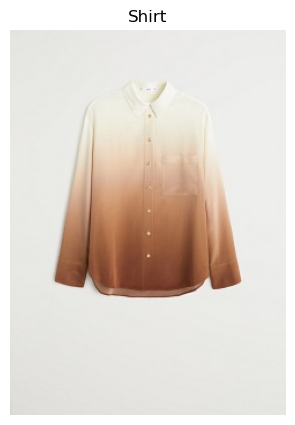


Identified Best Matching Category: Trousers & leggings - Trousers

Recommended Addition in 'Trousers & leggings - Trousers' category:


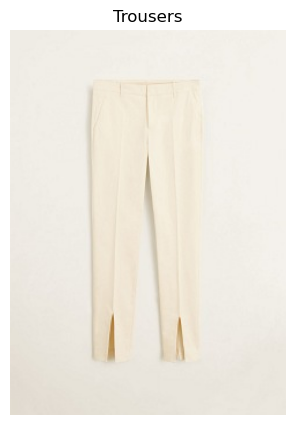


Outfit Composition After Adding Recommended Product:


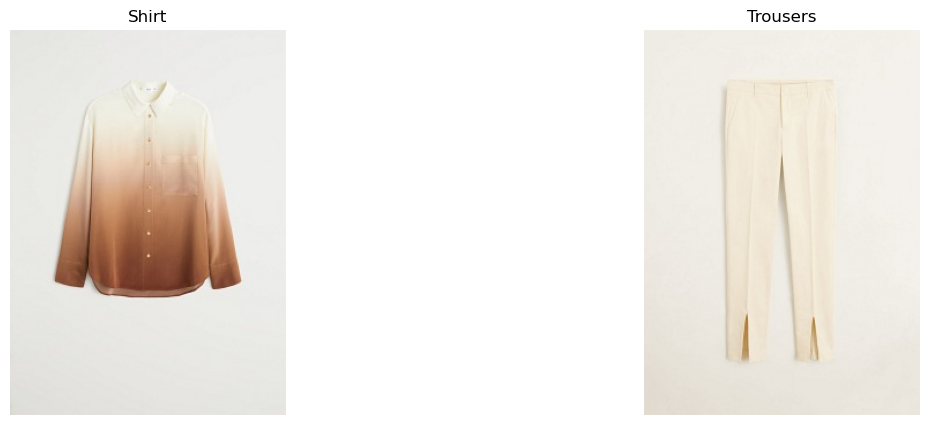

In [110]:
# Function to display product images
def display_product_images(outfit_data):
    # Display images for each product in the outfit
    fig, axes = plt.subplots(1, len(outfit_data), figsize=(15, 5))
    if len(outfit_data) == 1:
        axes = [axes]
    for ax, (index, row) in zip(axes, outfit_data.iterrows()):
        img = mpimg.imread(row['des_filename'])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{row['des_product_type']}")
    plt.show()

# Function to identify and exclude conflicting categories
def exclude_conflicting_categories(outfit_items):
    has_tshirt = any(item['des_product_family'] == 'T-shirt' for _, item in outfit_items.iterrows())
    has_shirt = any(item['des_product_family'] == 'Shirt' for _, item in outfit_items.iterrows())

    excluded_categories = []
    if has_tshirt:
        excluded_categories.append('Shirts - Shirt')
    if has_shirt:
        excluded_categories.append('T-shirts - T-shirt')

    return excluded_categories

# Function to calculate the best matching category
def find_best_matching_category(cod_modelo_color_list, missing_categories, outfit_product_data):
    outfit_items = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(cod_modelo_color_list)]

    # List of columns to include in the TF-IDF descriptions
    description_columns = [
        'cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng', 
        'des_sex', 'des_age', 'des_line', 'des_fabric', 
        'des_product_category', 'des_product_aggregated_family', 
        'des_product_family', 'des_product_type'
    ]

    # Creating enriched descriptions for the outfit
    outfit_descriptions = outfit_items[description_columns].astype(str).agg(' '.join, axis=1)

    # Initialize TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    outfit_vector = tfidf.fit_transform(outfit_descriptions)

    best_category = None
    highest_similarity = -1

    # Iterate over missing categories to find the best match
    for category in missing_categories:
        category_products = outfit_product_data[outfit_product_data['refined_category'] == category]
        category_descriptions = category_products[description_columns].astype(str).agg(' '.join, axis=1)

        if category_descriptions.empty:
            continue

        category_vector = tfidf.transform(category_descriptions)
        cosine_sim = cosine_similarity(outfit_vector, category_vector)
        average_similarity = np.mean(cosine_sim)

        if average_similarity > highest_similarity:
            highest_similarity = average_similarity
            best_category = category

    return best_category

# Function to recommend a product to complete an outfit
def recommend_product_for_outfit(cod_modelo_color_list, category_to_add, outfit_product_data):
    outfit_items = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(cod_modelo_color_list)]
    category_products = outfit_product_data[outfit_product_data['refined_category'] == category_to_add]

    # If there are no products in the desired category, return None
    if category_products.empty:
        print(f"No products available in the '{category_to_add}' category.")
        return None

    # List of columns to include in the TF-IDF descriptions
    description_columns = [
        'cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng', 
        'des_sex', 'des_age', 'des_line', 'des_fabric', 
        'des_product_category', 'des_product_aggregated_family', 
        'des_product_family', 'des_product_type'
    ]

    # Creating enriched descriptions by concatenating the values from the selected columns
    outfit_descriptions = outfit_items[description_columns].astype(str).agg(' '.join, axis=1)
    category_descriptions = category_products[description_columns].astype(str).agg(' '.join, axis=1)

    # Creating a TF-IDF Vectorizer to analyze product descriptions
    tfidf = TfidfVectorizer(stop_words='english')

    # Fitting the vectorizer to the descriptions
    tfidf_matrix = tfidf.fit_transform(category_descriptions)
    outfit_vector = tfidf.transform(outfit_descriptions)

    # Calculating cosine similarity between the outfit and the category products
    cosine_sim = cosine_similarity(outfit_vector, tfidf_matrix)

    # Finding the best matching product
    best_match_idx = np.argmax(np.sum(cosine_sim, axis=0))
    recommended_product = category_products.iloc[best_match_idx]

    # Return the recommended product as a DataFrame
    return pd.DataFrame([recommended_product])

# Main function to run the process
def process_outfit_recommendation(product_data, outfit_product_data, cod_modelo_color_list):
    # Filter the product data to only include the provided cod_modelo_color items
    outfit_items = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(cod_modelo_color_list)]

    # Check if there are any items in the provided list
    if outfit_items.empty:
        print("No items found for the provided cod_modelo_color list.")
        return

    # Delete the repeated items that share the same des_product_type
    outfit_items = outfit_items.drop_duplicates(subset=['des_product_type'])

    # Displaying the original outfits
    print("Provided Outfit Composition:")
    display_product_images(outfit_items)

    # Identify missing category types
    missing_types = identify_missing_category_types(outfit_items)

    # If there are no missing types, skip the recommendation
    if not missing_types:
        print("Outfit already contains products from all types.")
        return

    # Get categories to exclude
    excluded_categories = exclude_conflicting_categories(outfit_items)

    # Adjust missing categories based on missing types
    refined_categories = set()
    for category in missing_types:
        if category == 'Top':
            refined_categories.update(outfit_product_data[outfit_product_data['category_type'] == 'Top']['refined_category'])
        elif category == 'Bottom':
            refined_categories.update(outfit_product_data[outfit_product_data['category_type'] == 'Bottom']['refined_category'])

    refined_categories -= set(excluded_categories)

    # Find the best matching category using TF-IDF
    best_matching_category = find_best_matching_category(cod_modelo_color_list, refined_categories, outfit_product_data)
    if best_matching_category:
        print(f"\nIdentified Best Matching Category: {best_matching_category}")

        # Recommend a product in the selected missing category
        recommended_product = recommend_product_for_outfit(cod_modelo_color_list, best_matching_category, outfit_product_data)

        # If a product is recommended, display it and the updated outfit
        if recommended_product is not None:
            print(f"\nRecommended Addition in '{best_matching_category}' category:")
            display_product_images(recommended_product)

            # Adding the recommended product to the outfit
            updated_outfit = pd.concat([outfit_items, recommended_product])
            print("\nOutfit Composition After Adding Recommended Product:")
            display_product_images(updated_outfit)
        else:
            print("No suitable product found for recommendation.")
    else:
        print("No suitable category found for recommendation.")

# Function to determine the category type (Top, Bottom, etc.) based on the product family
def determine_category_type(row):
    top_families = ['T-shirt', 'Shirt', 'Blouse', 'Top']
    bottom_families = ['Trousers', 'Jeans', 'Skirt', 'Shorts']
    
    if row['des_product_family'] in top_families:
        return 'Top'
    elif row['des_product_family'] in bottom_families:
        return 'Bottom'
    else:
        return 'Other'
    
# Function to identify missing category types in the outfit
def identify_missing_category_types(outfit_items):
    existing_types = set(outfit_items['category_type'])
    all_types = {'Top', 'Bottom', 'Other'}
    return all_types - existing_types
    

# Merging outfit data with product data to get detailed attributes of products in outfits
outfit_product_data = outfit_data.merge(product_data, on='cod_modelo_color', how='left')

# Define a function to create a refined category
def create_refined_category(row):
    return f"{row['des_product_aggregated_family']} - {row['des_product_family']}"

# Apply this function to create a new 'refined_category' column
outfit_product_data['refined_category'] = outfit_product_data.apply(create_refined_category, axis=1)

# Apply this function to create a new 'category_type' column in the outfit_product_data
outfit_product_data['category_type'] = outfit_product_data.apply(determine_category_type, axis=1)

# List of cod_modelo_color items to use as an example
selected_items = ['51015740-02']

# Running the recommendation process
process_outfit_recommendation(product_data, outfit_product_data, selected_items)

In [ ]:
# Function to find potentially incompatible categories using TF-IDF
def find_potentially_incompatible_categories(outfit_product_data, threshold=0.1):
    description_columns = [
        'cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng', 
        'des_sex', 'des_age', 'des_line', 'des_fabric', 
        'des_product_category', 'des_product_aggregated_family', 
        'des_product_family', 'des_product_type'
    ]
    # Preparing category descriptions
    category_descriptions = {}
    for category in outfit_product_data['refined_category'].unique():
        category_products = outfit_product_data[outfit_product_data['refined_category'] == category]
        descriptions = category_products[description_columns].astype(str).agg(' '.join, axis=1)
        category_descriptions[category] = ' '.join(descriptions)

    # Vectorizing category descriptions
    categories = list(category_descriptions.keys())
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(category_descriptions.values())

    # Calculating cosine similarity between categories
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Finding pairs of categories with low similarity scores
    low_sim_pairs = []
    for i, j in combinations(range(len(categories)), 2):
        if cosine_sim[i, j] < threshold:
            low_sim_pairs.append((categories[i], categories[j]))

    return low_sim_pairs

# Updated function to check outfit composition rules
def check_outfit_rules(product_ids, outfit_product_data, incompatible_category_pairs):
    current_categories = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(product_ids)]['refined_category']
    incompatible_categories = set()

    # Existing logic
    has_dress = any('Dresses' in cat for cat in current_categories)
    if has_dress:
        incompatible_categories.update(['Bottoms', 'Skirts and shorts', 'Trousers & leggings', 'Jeans'])

    # New logic to avoid incompatible categories
    for cat in current_categories:
        for pair in incompatible_category_pairs:
            if cat in pair:
                incompatible_categories.update(pair)

    return incompatible_categories

# Function to recommend additional products avoiding the same subcategory
def recommend_additional_products_avoiding_same_subcategory(product_ids, num_products_to_add, outfit_product_data, incompatible_category_pairs):
    existing_subcategories = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(product_ids)]['des_product_family'].unique()
    incompatible_categories = check_outfit_rules(product_ids, outfit_product_data, incompatible_category_pairs)
    
    print("Existing Subcategories:", existing_subcategories)
    print("Incompatible Categories:", incompatible_categories)

    recommendations = []
    for _ in range(num_products_to_add):
        # Allow some overlap in categories for more flexibility
        # Example: Allow different types of tops or different accessories
        relaxed_incompatibility = set([cat.split(' - ')[0] for cat in incompatible_categories])
        available_categories = outfit_product_data[
            ~outfit_product_data['refined_category'].str.split(' - ').str[0].isin(relaxed_incompatibility)
        ]['refined_category'].unique()

        print("Available Categories:", available_categories)

        if len(available_categories) == 0:
            print("No more suitable categories available for recommendation.")
            break

        category_to_add = random.choice(available_categories)
        recommended_product = recommend_product_for_category(product_ids, category_to_add, outfit_product_data)
        if recommended_product is not None:
            recommendations.append(recommended_product)
    
    return pd.concat(recommendations) if recommendations else None



# Function to recommend a product for a specific category using TF-IDF and Cosine Similarity
def recommend_product_for_category(product_ids, category, outfit_product_data):
    # Filter products in the desired refined category
    category_products = outfit_product_data[outfit_product_data['refined_category'] == category]
    if category_products.empty:
        print(f"No products available in the '{category}' category.")
        return None

    # Filter given products
    given_products = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(product_ids)]

    # List of columns to include in the TF-IDF descriptions
    description_columns = [
        'cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng', 
        'des_sex', 'des_age', 'des_line', 'des_fabric', 
        'des_product_category', 'des_product_aggregated_family', 
        'des_product_family', 'des_product_type'
    ]

    # Creating enriched descriptions
    given_descriptions = given_products[description_columns].astype(str).agg(' '.join, axis=1)
    category_descriptions = category_products[description_columns].astype(str).agg(' '.join, axis=1)

    # Creating a TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words='english')

    # Fitting the vectorizer to the category descriptions and transforming the given product descriptions
    tfidf_matrix = tfidf.fit_transform(category_descriptions)
    given_vector = tfidf.transform(given_descriptions)

    # Calculating cosine similarity between the given products and the category products
    cosine_sim = cosine_similarity(given_vector, tfidf_matrix)

    # Finding the best matching product
    best_match_idx = np.argmax(np.sum(cosine_sim, axis=0))
    recommended_product = category_products.iloc[best_match_idx]

    # Ensure the recommended product is returned as a DataFrame
    recommended_product = category_products.iloc[[best_match_idx]]
    return recommended_product

# Function to display products based on their identifiers
def display_product_images(outfit_data):
    # Check if outfit_data is a Series and convert it to DataFrame if necessary
    if isinstance(outfit_data, pd.Series):
        outfit_data = pd.DataFrame([outfit_data])

    # Display images for each product in the outfit
    fig, axes = plt.subplots(1, len(outfit_data), figsize=(15, 5))
    if len(outfit_data) == 1:
        axes = [axes]
    for ax, (index, row) in zip(axes, outfit_data.iterrows()):
        img = mpimg.imread(row['des_filename'])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{row['des_product_type']}")
    plt.show()

def display_products_by_ids(product_ids, product_data):
    products_to_display = product_data[product_data['cod_modelo_color'].isin(product_ids)]
    display_product_images(products_to_display)

# Function to process the entire recommendation
def process_custom_outfit_recommendation(product_ids, num_products_to_add, product_data, outfit_product_data, incompatible_category_pairs):
    print("Original Products:")
    display_products_by_ids(product_ids, product_data)

    recommended_products = recommend_additional_products_avoiding_same_subcategory(product_ids, num_products_to_add, outfit_product_data, incompatible_category_pairs)
    if recommended_products is not None and not recommended_products.empty:
        print("\nRecommended Products:")
        display_product_images(recommended_products)
    else:
        print("No additional products recommended.")

# Merging outfit data with product data
outfit_product_data = outfit_data.merge(product_data, on='cod_modelo_color', how='left')

# Define a function to create a refined category
def create_refined_category(row):
    return f"{row['des_product_aggregated_family']} - {row['des_product_family']}"

# Apply this function to create a new 'refined_category' column
outfit_product_data['refined_category'] = outfit_product_data.apply(create_refined_category, axis=1)

# Run Incompatibility Analysis
incompatible_category_pairs = find_potentially_incompatible_categories(outfit_product_data)

# Example usage
selected_product_ids = ['53045718-17', '47049204-99', '57042890-99']
process_custom_outfit_recommendation(selected_product_ids, 2, product_data, outfit_product_data, incompatible_category_pairs)

In [ ]:
# Function to display product images
def display_product_images(outfit_data, product_data):
    fig, axes = plt.subplots(1, len(outfit_data), figsize=(15, 5))
    if len(outfit_data) == 1:
        axes = [axes]
    for ax, product_id in zip(axes, outfit_data):
        product_row = product_data[product_data['cod_modelo_color'] == product_id].iloc[0]
        img = mpimg.imread(product_row['des_filename'])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{product_row['des_product_type']}")
    plt.show()

# Function to analyze the given list of products and recommend if needed
def analyze_and_recommend_products(product_list, product_data, outfit_product_data):
    # Retrieve product details from the product list
    products_info = product_data[product_data['cod_modelo_color'].isin(product_list)]
    
    # Check for the presence of key outfit components
    has_top = any('Top' in cat for cat in products_info['des_product_type'])
    has_bottom = any('Bottom' in cat for cat in products_info['des_product_type'])
    has_footwear = any('Footwear' in cat for cat in products_info['des_product_type'])
    has_dress = any('Dress' in cat for cat in products_info['des_product_type'])

    # Define the missing categories
    missing_categories = []
    if not has_top and not has_dress:
        missing_categories.append('Top')
    if not has_bottom and not has_dress:
        missing_categories.append('Bottom')
    if not has_footwear:
        missing_categories.append('Footwear')

    # If outfit rules are met, randomly choose a category to recommend a product
    if not missing_categories:
        available_categories = list(set(outfit_product_data['refined_category']) - set(['Dress']))
        recommended_category = random.choice(available_categories)
    else:
        recommended_category = random.choice(missing_categories)

    # Recommend a product from the selected category
    recommended_product = recommend_product_for_outfit(None, recommended_category, outfit_product_data)

    # Display the selected products
    print("Selected Products:")
    display_product_images(product_list, product_data)

    # Display the recommended product, if any
    if recommended_product is not None:
        print(f"\nRecommended Product in '{recommended_category}' category:")
        display_product_images(recommended_product['cod_modelo_color'].tolist(), product_data)

# Merging outfit data with product data
outfit_product_data = outfit_data.merge(product_data, on='cod_modelo_color', how='left')

# Define a function to create a refined category
def create_refined_category(row):
    return f"{row['des_product_aggregated_family']} - {row['des_product_family']}"

# Apply this function to create a new 'refined_category' column
outfit_product_data['refined_category'] = outfit_product_data.apply(create_refined_category, axis=1)

# Run Incompatibility Analysis
incompatible_category_pairs = find_potentially_incompatible_categories(outfit_product_data)

# Example usage
selected_product_ids = ['53045718-17', '47049204-99', '57042890-99']
analyze_and_recommend_products(selected_product_ids, product_data, outfit_product_data)

In [ ]:
from itertools import combinations
from collections import Counter

def analyze_category_combinations(outfit_product_data):
    # Extracting categories from each outfit
    outfit_categories = outfit_product_data.groupby('cod_outfit')['refined_category'].apply(list)

    # Counting occurrences of each category pair in the outfits
    category_pair_counter = Counter()
    for categories in outfit_categories:
        for pair in combinations(set(categories), 2):
            category_pair_counter[pair] += 1

    # Identifying category pairs that never or rarely occur together
    rare_pairs = [pair for pair, count in category_pair_counter.items() if count < 2]
    return rare_pairs

# Example usage
rare_category_pairs = analyze_category_combinations(outfit_product_data)

print("Rare Category Pairs:")
for pair in rare_category_pairs:
    print(pair)

In [ ]:
# Function to analyze category combinations
def analyze_category_combinations(outfit_product_data):
    outfit_categories = outfit_product_data.groupby('cod_outfit')['refined_category'].apply(list)
    category_pair_counter = Counter()
    for categories in outfit_categories:
        for pair in combinations(set(categories), 2):
            category_pair_counter[pair] += 1

    # Threshold can be adjusted based on dataset analysis
    threshold = 5
    rare_pairs = [pair for pair, count in category_pair_counter.items() if count < threshold]
    return set(rare_pairs)

# Function to detect clashes in the outfit
def detect_clashes(outfit_items, rare_category_pairs):
    outfit_categories = outfit_items['refined_category'].tolist()
    for pair in combinations(outfit_categories, 2):
        if pair in rare_category_pairs or (pair[1], pair[0]) in rare_category_pairs:
            return True
    return False

# Function to recommend a product of a different class
def recommend_different_class_product(input_products, outfit_product_data, product_data):
    # Exclude categories present in input_products
    excluded_categories = input_products['refined_category'].unique()
    available_products = outfit_product_data[~outfit_product_data['refined_category'].isin(excluded_categories)]

    # Check if there are available products to recommend
    if available_products.empty:
        print("No available products in different categories.")
        return None
    
    description_columns = [
        'cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng', 
        'des_sex', 'des_age', 'des_line', 'des_fabric', 
        'des_product_category', 'des_product_aggregated_family', 
        'des_product_family', 'des_product_type'
    ]

    # Creating enriched descriptions by concatenating relevant values
    input_descriptions = input_products[description_columns].astype(str).agg(' '.join, axis=1)
    available_descriptions = available_products[description_columns].astype(str).agg(' '.join, axis=1)

    # Creating a TF-IDF Vectorizer to analyze product descriptions
    tfidf = TfidfVectorizer(stop_words='english')

    # Fitting the vectorizer to the descriptions of available products
    tfidf_matrix = tfidf.fit_transform(available_descriptions)
    input_vector = tfidf.transform(input_descriptions)

    # Calculating cosine similarity between the input products and available products
    cosine_sim = cosine_similarity(input_vector, tfidf_matrix)

    # Finding the best matching product
    best_match_idx = np.argmax(np.sum(cosine_sim, axis=0))
    recommended_product = available_products.iloc[best_match_idx]

    # Return the recommended product as a DataFrame
    return pd.DataFrame([recommended_product])


# Modified main function to handle a list of products
def process_outfit_recommendation_with_list(input_products_list, product_data, outfit_product_data, rare_category_pairs):
    input_products = outfit_product_data[outfit_product_data['cod_modelo_color'].isin(input_products_list)]
    # Filter out repeated products
    input_products = input_products.drop_duplicates(subset=['cod_modelo_color'])
    print("Input Products:")
    display_product_images(input_products)

    if detect_clashes(input_products, rare_category_pairs):
        print("Clash detected in input products.")
        return

    recommended_product = recommend_different_class_product(input_products, outfit_product_data, product_data)
    if recommended_product is not None:
        print("Recommended Product:")
        display_product_images(recommended_product)
    else:
        print("No suitable product found for recommendation.")

# Read data and prepare dataset
product_data = pd.read_csv('datathon/dataset/product_data.csv')
outfit_data = pd.read_csv('datathon/dataset/outfit_data.csv')
outfit_product_data = outfit_data.merge(product_data, on='cod_modelo_color', how='left')
outfit_product_data['refined_category'] = outfit_product_data.apply(create_refined_category, axis=1)

# Analyzing historical data for rare category pairs
rare_category_pairs = analyze_category_combinations(outfit_product_data)

selected_product_ids = ['57084388-99', '53047022-51', '53050655-28']
process_outfit_recommendation_with_list(selected_product_ids, product_data, outfit_product_data, rare_category_pairs)